While browsing the chapter on the harmonic oscillator in Griffith's textbook, I learned something interesting:

> Equation 2.70 [the time-independent Schrödinger equation] has solutions, of course, for
> *any* value of $E$ (in fact, it has *two* linearly independent solutions for every $E$)  
> *David J. Griffith, Introduction to Quantum Mechanics, 2nd ed, pg. 54*

It is just so common to think of the time-independent Schrödinger equation in terms
of an *eigenwert* problem, that one simply assumes discrete eigenvalues $E_n$ (making the transition to matrix algebra without noticing).
But on the other hand the Schrödinger equation is just an ODE and there should be solutions for
*every* value of $E$! These "solutions", however, will not be valid quantum mechanical states as we will see.

Let's take a look at the time-independent Schrödinger equation:

$$
E \psi(x) = 
\left(-\frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2} + V(x) \right) \psi(x)
$$

This is just a second order ODE:

$$
\frac{\partial^2}{\partial x^2} \psi(x) = \frac{2m}{\hbar^2} \left( V(x) - E \right) \psi(x)
$$

which should give a solution $\psi(x)$ for every value of $E$. But finding this solution
can not be done analytically in most cases. Here we will use numerical methods for
solving ordinary differential equations.

## Solving an ODE numerically

Suppose we have a first order ODE like:

$$
\frac{d}{dx} y(x) = F(x, y(x))
$$

A way to solve such an ODE numerically is by **discretization**:

We are looking for the solution $y(x)$ in the interval $x \in [x_0, x_N]$, 
but for the numerical treatment we just consider the function at discrete values of $x$:

$$
x \in \{ x_0 + n \Delta x \, | \,  n \in \mathbb{N}_0 \land n \leq N \}
$$

with $\Delta x = (x_N - x_0) / N$.

Now we approximate the derivative $\frac{d}{dx} y(x)$ using only these sampling points:

$$
\frac{d}{dx} y(x_n) \approx \frac{y(x_{n+1}) - y(x_n)}{\Delta x}
$$

With this, we get a simple recipe, to find $y(x_{n+1})$ based on the value at $x_n$:

$$
y(x_{n+1}) \approx y(x_n) + \Delta x F(x_n, y(x_n)) 
$$

So, starting from an *initial condition* value $y(x_0)$ we can find $y(x_1)$. Taking this value
we can calculate $y(x_2)$ and so until we reach $y(x_N)$. This way, we find an approximation
for the complete function $y(x)$ on the sampling points.

This method is known as the [Euler method][euler]. It is the simplest integration method for an ODE,
but it has a major drawback, because it is numerically [unstable][unstable] and the integration
errors are quite large.

There are better integration methods, like [Runge-Kutta methods][runge]. Luckily these
methods are readily available in SciPy, by using the `solve_ivp()` function from the `scipy.integrate` module.

[euler]: https://en.wikipedia.org/wiki/Euler_method
[unstable]: https://en.wikipedia.org/wiki/Euler_method#Numerical_stability
[runge]: https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods

## Converting the second order ODE into two first order ODEs

The numerical solvers usually handle only first order ODEs, so we have to convert the
Schrödinger equation into two first order ODEs. For this we define a two-dimensional vector:

$$
y(x) = 
\begin{pmatrix}
\psi(x) \\
\psi'(x)
\end{pmatrix}
$$

and the function $F(x, y(x))$ becomes vector-valued too:

$$
F(x, y(x)) = \begin{pmatrix}
\psi'(x) \\
\left( V(x) - E \right) \psi(x)
\end{pmatrix}
$$

which gives

$$
\frac{d}{dx} \begin{pmatrix}
\psi(x) \\
\psi'(x)
\end{pmatrix} =
\begin{pmatrix}
\psi'(x) \\
\left( V(x) - E \right) \psi(x)
\end{pmatrix}
$$

So taking the derivative of the fist row and then applying the second row to the RHS yields the original second 
order ODE:

$$
\frac{d}{dx} \frac{d}{dx} \psi(x) = \frac{d}{dx} \psi'(x) = \left( V(x) - E \right) \psi(x)
$$

As written above, for the start of the iterative solution we need the *initial condition* $y(x_0)$.
Now $y(x)$ is a vector consisting of $\psi(x)$ and $\psi'(x)$, so we need two initial values, $\psi(x_0)$
and $\psi'(x_0)$.
This is similar to the solution to *Newton's* equation for a particle, where we need a starting position, $x$, and 
a starting velocity, $v = \dot x$.

**Side note:**  
As the Schrödinger equation is a linear ODE, we can write the vector-valued ODE using matrix multiplication:

$$
\frac{d}{dx} \begin{pmatrix}
\psi \\
\psi'
\end{pmatrix} =
\begin{pmatrix}
0 &  1 \\
V(x) - E & 0
\end{pmatrix}
\begin{pmatrix}
\psi \\
\psi'
\end{pmatrix}
$$

## Application to the Harmonic Oscillator

The harmonic oscillator has the Hamiltonian:

$$
\hat H = \frac{1}{2m} \hat p^2 + \frac{1}{2} m \omega^2 \hat x^2
$$

and the time-independent Schrödinger equation (in position space):

$$
E \psi(x) = -\frac{\hbar^2}{2m} \frac{\partial^2 \psi(x)}{\partial x^2} + \frac{1}{2} m \omega^2 x^2 \psi(x)
$$


As we have seen [previously][yak] the eigenvalues of the Hamiltonian

$$
\hat H \psi_n(x) = E_n \psi_n(x)
$$

can be found as

$$
E_n = \hbar \omega \left( n + \frac{1}{2} \right)
$$

So the energy eigenstates are discrete. But, on the other hand, the Schrödinger differential equation 
can be solved for any energy. How do wavefunctions look like for energies other than the eigenvalues?

To answer this question, we will use the numerical solving method, which we described above. First, the
usual python imports:

[yak]: https://znswanderer.github.io/blog/Harmonic-Oscillator-SymPy/

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [26]:
plt.rcParams['figure.dpi'] = 300
#plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('figure', figsize = (5, 4))    # Reduces overall size of figures
plt.style.use(['science', 'notebook', 'grid', 'vibrant'])
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

For the numerical solution we need a function $F(x, y(x))$, that will take the
argument 

$$
y(x) = \begin{pmatrix}
    \psi(x) \\
    \psi'(x)
\end{pmatrix}
$$

and return the RHS of the differential equation for the harmonic oscillator:

$$
F(x, y(x)) = \begin{pmatrix}
    \psi'(x) \\
    \left( x^2 - 2 E \right) \psi(x)
\end{pmatrix}
$$

(for $\hbar = 1$, $m =1$ and $\omega = 1$)

This is done in this python function:

In [23]:
# Harmonic Oscillator
def harmonic(E):
    def F(x, y):
        psi, ddx_psi = y
        return [ddx_psi, (x**2 - 2*E) * psi]    
    return F

As discussed above, in order to start the integration we need initial conditions for $\psi$ and $\psi'$. 
We also have to decide on the starting position $x_0$. 

To get a feeling for the numerics, we first start with the known solution for $n=0$ and $E_0 = 1/2$.
This is the symmetric gaussion curve centered at $x=0$. So we start the integration at $x_0 = 0$,
setting $\psi(x_0) = 1$ arbitrarily and $\psi'(x_0) = 0$, because the curve has an extremum at this
point.

We use the Runge-Kutta method 'DOP853' in the integration and set the error tolerances quite low, 
because the system is very unstable, as we will see.

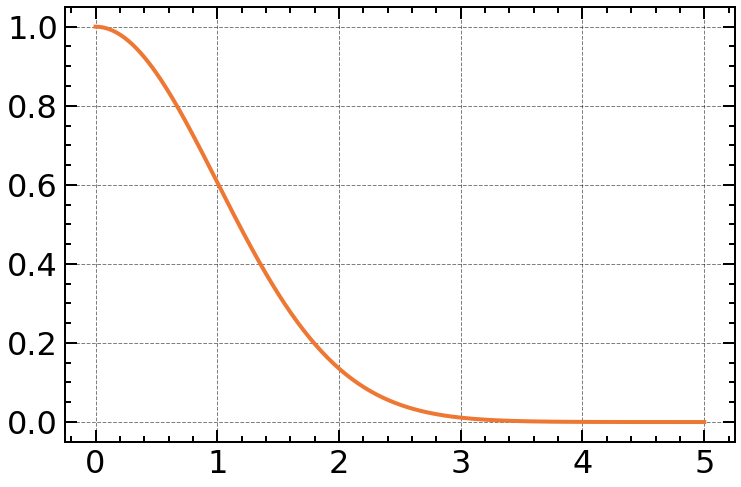

In [77]:
x = np.linspace(0, 5, 300)
sol_hlf = solve_ivp(harmonic(0.5), [x[0], x[-1]], [1, 0], t_eval=x, method = 'DOP853', 
                    rtol=1e-13, atol=1e-18)
plt.plot(sol_hlf.t, sol_hlf.y[0]);

To check, if the numerical solution really yields the symmetric function, we will 
now take the final result at $x=5$ and use this to define a new starting positon
with $\psi(x_0 = -5) = \psi(5)$ and $\psi'(-5) = - \psi'(5)$. And this indeed
integrates to a symmetrical solution, as expected:

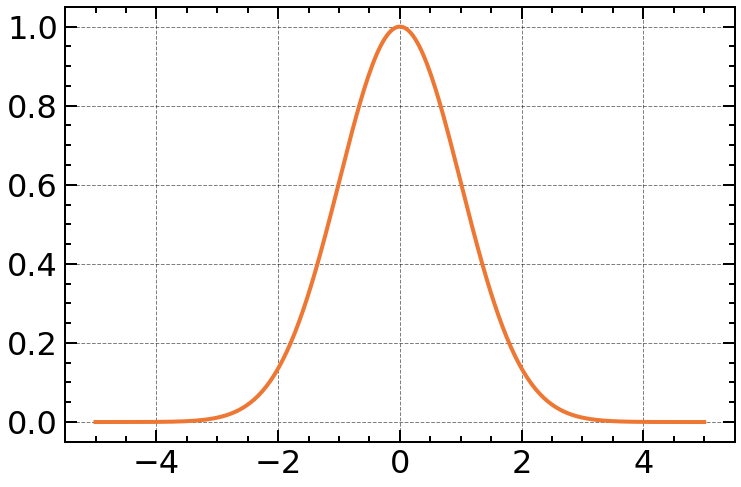

In [78]:
x = np.linspace(-5, 5, 300)
sol = solve_ivp(harmonic(0.5), [x[0], x[-1]], [sol_hlf.y[0][-1], -sol_hlf.y[1][-1]], 
                t_eval=x, method = 'DOP853', rtol=1e-13, atol=1e-18)
plt.plot(sol.t, sol.y[0]);

But what happens if we choose $E$ to be slightly above or below the eigenvalue?

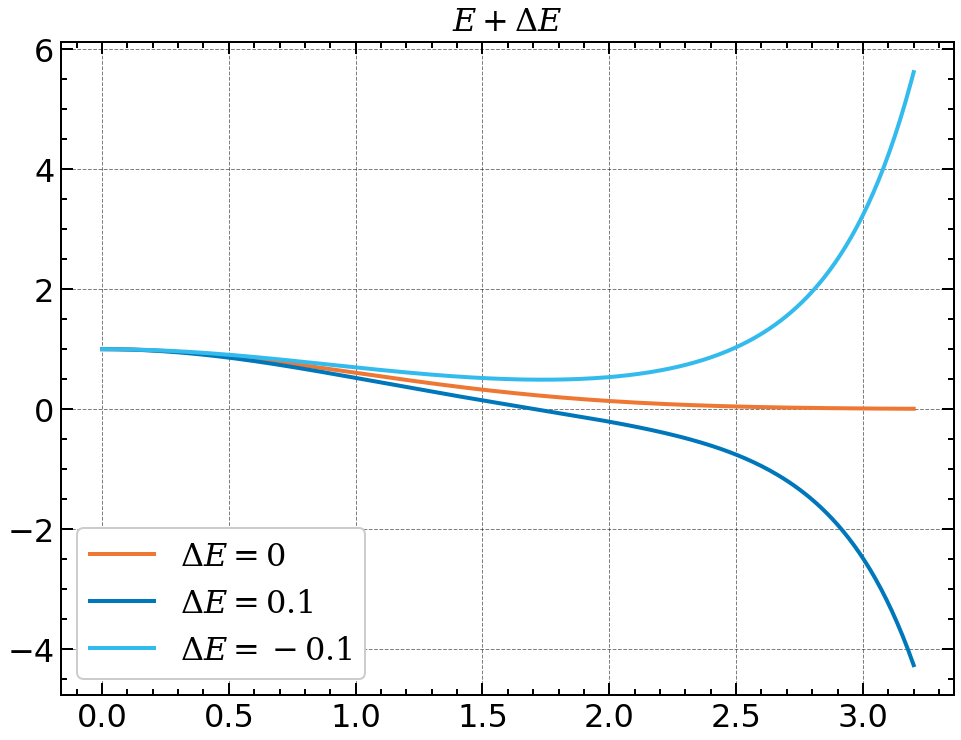

In [80]:
plt.figure(figsize=(8,6))
x = np.linspace(0, 3.2, 300)
for dE in (0, 0.1, -0.1):
    sol_hlf = solve_ivp(harmonic(0.5 + dE), [x[0], x[-1]], [1, 0], t_eval=x, 
                        method = 'DOP853', rtol=1e-13, atol=1e-18)
    plt.plot(sol_hlf.t, sol_hlf.y[0], label=r"$\Delta E = {}$".format(dE))

plt.title(r"$E + \Delta E$")
plt.legend(loc='lower left');

For an energy value that is *not* an eigenvalue of the Hamiltonian the corresponding wave function
**diverges!** And this means, these functions can not be normalized and so they do not represent 
a quantum system. They are not elements of the Hilbert space for this system.

As Griffith puts it:

> As you tweak the parameter [the energy] in tiny increments from 0.49 to 0.51, the tails flip over when you
> pass through 0.5 &mdash; only at *precisely* 0.5 do the tails go to zero, leaving a normalizable solution.  
> *David J. Griffith, Introduction to Quantum Mechanics, 2nd ed, pg. 54*

So, the time-independet Schrödinger equation has solutions for every value of $E$, but
only at the discrete ernergy levels these solutions can be normalized and hence be
wave functions for a quantum system.

The searching of eigenvalues by modifying the energy value $E$ is called *shooting method*. 
For further information you can take a look at the corresponding [wikipedia page][wiki].

[wiki]: https://en.wikipedia.org/wiki/Shooting_method

## Bonus: the other wave function

As cited in the introduction of this blog post: there are two *linearly independent* solutions
for every energy. So let's take the "allowed" energy value $E = 0.5$ and see, if we can find the
second wave function for this energy.

The Hamiltonian of the harmonic oscillator is symmetric with respect to $x=0$ and we know
that the eigenfunctions are either symmetric or anti-symmetric. The correct solution
for $E=0.5$ is a symmetric function, so it would be a good guess, that the 
second solution must be anti-symmetric.

We can enforce an antisymmetric solution by applying the intial conditions $\psi(0) = 0$ and $\psi'(0) \neq 0$.
Let's try this:

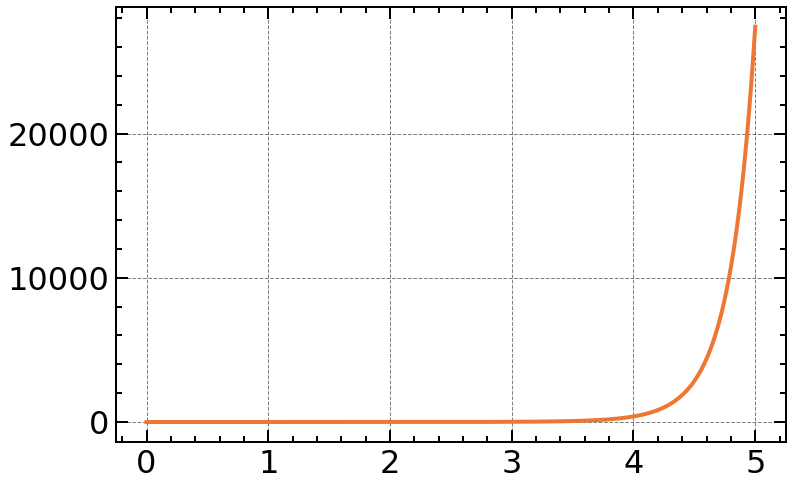

In [76]:
x = np.linspace(0, 5, 300)
sol_hlf = solve_ivp(harmonic(0.5), [x[0], x[-1]], [0, 1], t_eval=x, method = 'DOP853',
                    rtol=1e-13, atol=1e-18)
plt.plot(sol_hlf.t, sol_hlf.y[0]);

So the second solution for $E=0.5$ blows up too and can not be a "real" solution for the quantum system.

All *valid* solutions are indeed the solutions we found [previously][prev] with the ladder-operators.

[prev]: https://znswanderer.github.io/blog/Harmonic-Oscillator-SymPy/